In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
%cd drive/My\ Drive/Project/PlantDiseaseDetector

/content/drive/My Drive/Project/PlantDiseaseDetector


In [0]:
try:
  # The %tensorflow_version magic only works in colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import tensorflow_hub as hub
import os

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [0]:
#Load data
zip_file=tf.keras.utils.get_file(origin='https://storage.googleapis.com/plantdata/PlantVillage.zip', 
 fname='PlantVillage.zip', extract=True)

856842240/856839084 [==============================] - 12s 0us/step


In [0]:
#Create the training and validation directories
data_dir = os.path.join(os.path.dirname(zip_file), 'PlantVillage')
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')

In [0]:
#!wget https://github.com/obeshor/Plant-Diseases-Detector/archive/master.zip
#!unzip master.zip;
import json
with open('Plant-Diseases-Detector-master/categories.json', 'r') as f:
    cat_to_name = json.load(f)
    classes = list(cat_to_name.values())

In [0]:
print (classes)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

In [0]:
module_selection = ("inception_v3", 299, 2048) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 64 #@param {type:"integer"}

In [0]:
module_selection

('inception_v3', 299, 2048)

In [0]:
# Inputs are suitably resized for the selected module.
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

Found 10861 images belonging to 38 classes.


In [0]:
do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest' )
else:
  train_datagen = validation_datagen

In [0]:
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

Found 43444 images belonging to 38 classes.


In [0]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE+(3,),
                                   output_shape=[FV_SIZE])

In [0]:
do_fine_tuning = False #@param {type:"boolean"}
if do_fine_tuning:
  feature_extractor.trainable = True
  # unfreeze some layers of base network for fine-tuning
  for layer in feature_extractor.layers[-30:]:
      layer.trainable =True
  
else:
  feature_extractor.trainable = False

In [0]:
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])

In [0]:
model.summary()

In [0]:
#Compile model specifying the optimizer learning rate
LEARNING_RATE = 0.001 #@param {type:"number"}
model.compile(
   optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])

In [0]:
!ls

checkpoint			PlantVillage.zip	       tflite_models
master.zip			test_2019_11_22_14_03_41.hdf5  training
Plant-Diseases-Detector-master	test_2019_11_22_14_04_55.hdf5


In [0]:
checkpoint_path = "training/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    period=1)

In [0]:
EPOCHS=11 #@param {type:"integer"}
STEPS_EPOCHS = train_generator.samples//train_generator.batch_size
VALID_STEPS=validation_generator.samples//validation_generator.batch_size
history = model.fit_generator( 
          train_generator,
          steps_per_epoch=STEPS_EPOCHS,
          epochs=EPOCHS,
          validation_data=validation_generator,
          validation_steps=VALID_STEPS)

Epoch 1/11
678/678 [==============================] - 1112s 2s/step - loss: 0.4017 - acc: 0.8720 - val_loss: 0.3735 - val_acc: 0.8763
Epoch 2/11
678/678 [==============================] - 1094s 2s/step - loss: 0.3456 - acc: 0.8884 - val_loss: 0.2813 - val_acc: 0.9090
Epoch 3/11
678/678 [==============================] - 1094s 2s/step - loss: 0.3134 - acc: 0.8983 - val_loss: 0.2551 - val_acc: 0.9160
Epoch 4/11
678/678 [==============================] - 1094s 2s/step - loss: 0.3016 - acc: 0.9015 - val_loss: 0.2655 - val_acc: 0.9138
Epoch 5/11
678/678 [==============================] - 1104s 2s/step - loss: 0.2839 - acc: 0.9078 - val_loss: 0.2488 - val_acc: 0.9175
Epoch 6/11
678/678 [==============================] - 1104s 2s/step - loss: 0.2759 - acc: 0.9089 - val_loss: 0.2289 - val_acc: 0.9214
Epoch 7/11
678/678 [==============================] - 1107s 2s/step - loss: 0.2595 - acc: 0.9149 - val_loss: 0.2084 - val_acc: 0.9312
Epoch 8/11
678/678 [==============================] - 1111s 2s

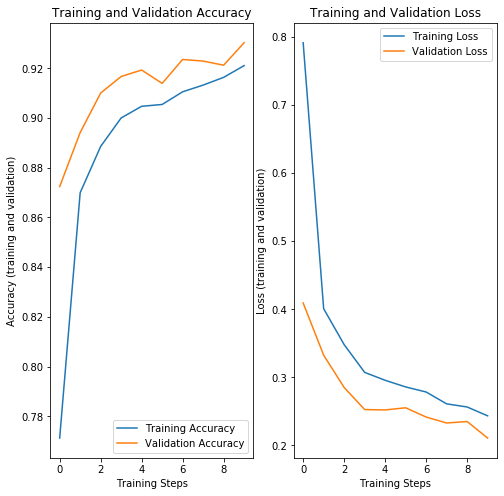

In [0]:
import matplotlib.pylab as plt
import numpy as np
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

SOURCE: class: Tomato___Spider_mites Two-spotted_spider_mite, file: Tomato___Spider_mites Two-spotted_spider_mite/aadcf7d6-56f1-495c-a099-8fca2f2e79e1___Com.G_SpM_FL 1392.JPG
PREDICTED: class: Tomato___Spider_mites Two-spotted_spider_mite, confidence: 0.892261


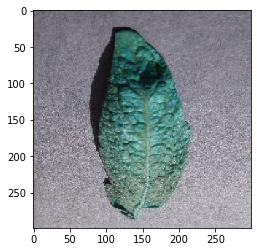

<Figure size 432x288 with 0 Axes>

SOURCE: class: Soybean___healthy, file: Soybean___healthy/2e8eb6cd-003c-4c15-b9ec-16cdaecbd7e3___RS_HL 7273.JPG
PREDICTED: class: Soybean___healthy, confidence: 0.999999


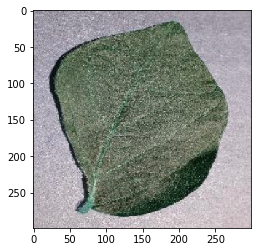

SOURCE: class: Tomato___Late_blight, file: Tomato___Late_blight/78863d29-72bb-494d-8f05-c5648130283f___GHLB2 Leaf 9112.JPG
PREDICTED: class: Tomato___Late_blight, confidence: 0.987777


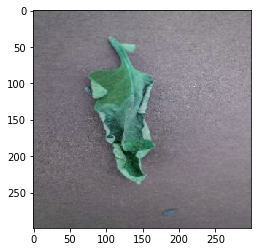

<Figure size 432x288 with 0 Axes>

SOURCE: class: Squash___Powdery_mildew, file: Squash___Powdery_mildew/f2dacd48-43c6-4be9-a3cc-fe9ee20a939d___MD_Powd.M 0061.JPG
PREDICTED: class: Squash___Powdery_mildew, confidence: 0.315230


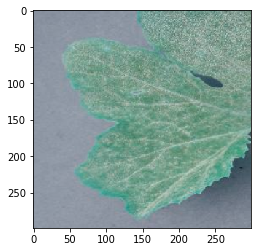

<Figure size 432x288 with 0 Axes>

SOURCE: class: Orange___Haunglongbing_(Citrus_greening), file: Orange___Haunglongbing_(Citrus_greening)/fde2976b-9620-4965-afe8-03ab320c9cde___CREC_HLB 5069.JPG
PREDICTED: class: Orange___Haunglongbing_(Citrus_greening), confidence: 0.999842


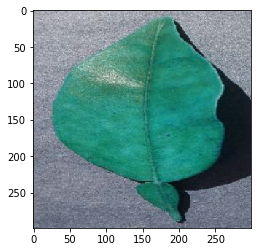

<Figure size 432x288 with 0 Axes>

In [0]:
# Import OpenCV
import cv2
# Utility
import itertools
import random
import numpy as np
import matplotlib.pylab as plt
from collections import Counter
from glob import iglob
def load_image(filename):
    img = cv2.imread(os.path.join(data_dir, validation_dir, filename))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255
    
    return img
def predict(image):
    probabilities = new_model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}
for idx, filename in enumerate(random.sample(validation_generator.filenames, 5)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

### Inference

In [0]:
# Import OpenCV
import cv2

# Utility
import itertools
import random
from collections import Counter
from glob import iglob
import numpy as np
import sys


def load_image(filename):
    img = cv2.imread(os.path.join(data_dir, validation_dir, filename))
    print(filename, ":", img)
    img = cv2.resize(img, (IMAGE_SHAPE[0], IMAGE_SHAPE[1]) )
    print("resized:", img)
    img = img /255
    print("Normalized",img)
    
    return img


def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    print("After Softmax", probabilities)
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

In [0]:
if any("c0c3498a-4b3c-49b0-b44f-2b3f0d7a6ebb___RS_HL 2372.JPG" in s for s in validation_generator.filenames):
  print(True)
matching = [s for s in validation_generator.filepaths if "c0c3498a-4b3c-49b0-b44f-2b3f0d7a6ebb___RS_HL 2372.JPG" in s]
print(matching)

True
['/root/.keras/datasets/PlantVillage/validation/Blueberry___healthy/c0c3498a-4b3c-49b0-b44f-2b3f0d7a6ebb___RS_HL 2372.JPG']


In [0]:
np.set_printoptions(threshold=sys.maxsize)

In [0]:
img = cv2.imread('/root/.keras/datasets/PlantVillage/validation/Blueberry___healthy/c0c3498a-4b3c-49b0-b44f-2b3f0d7a6ebb___RS_HL 2372.JPG')
# print(img)

In [0]:
img = cv2.resize(img, (IMAGE_SHAPE[0], IMAGE_SHAPE[1]) )
img

In [0]:
img = img / 255
img

In [0]:
new_model.predict(np.asarray([img]))[0]

array([4.6510851e-07, 2.2118666e-08, 7.2860371e-09, 2.5625669e-03,
       9.9740797e-01, 4.0713604e-07, 6.0860458e-07, 1.8846893e-11,
       2.4848626e-12, 3.5132546e-11, 2.0301982e-09, 1.5751841e-09,
       6.1362911e-12, 2.5331942e-13, 2.5936744e-12, 4.9445212e-08,
       1.1052828e-09, 1.2400291e-10, 1.1722995e-10, 2.8861045e-09,
       2.2245803e-12, 4.9718119e-07, 4.3223460e-07, 5.1047064e-09,
       2.2830574e-05, 5.6818165e-11, 4.2907910e-11, 1.7561041e-07,
       7.1636391e-10, 6.8038450e-09, 2.9787718e-06, 2.9060745e-08,
       2.4517002e-09, 4.8934942e-07, 3.7937795e-08, 7.4077233e-09,
       2.7334131e-11, 4.8361602e-07], dtype=float32)

In [0]:
class_idx = np.argmax(new_model.predict(np.asarray([img]))[0])

In [0]:
class_idx

4

SOURCE: class: Apple___Apple_scab, file: Apple___Apple_scab/656265b3-9f9a-4a20-83f5-e5d6be938dcd___FREC_Scab 3454.JPG
Apple___Apple_scab/656265b3-9f9a-4a20-83f5-e5d6be938dcd___FREC_Scab 3454.JPG : [[[148 104 111]
  [148 104 111]
  [147 103 110]
  ...
  [155 110 119]
  [155 110 119]
  [155 110 119]]

 [[146 102 109]
  [144 100 107]
  [142  98 105]
  ...
  [155 110 119]
  [155 110 119]
  [155 110 119]]

 [[145 101 108]
  [143  99 106]
  [141  97 104]
  ...
  [155 110 119]
  [155 110 119]
  [156 111 120]]

 ...

 [[194 158 158]
  [186 150 150]
  [188 152 152]
  ...
  [177 143 149]
  [170 136 142]
  [173 139 145]]

 [[184 148 148]
  [190 154 154]
  [185 149 149]
  ...
  [176 142 148]
  [170 136 142]
  [174 140 146]]

 [[174 138 138]
  [188 152 152]
  [177 141 141]
  ...
  [177 143 149]
  [175 141 147]
  [181 147 153]]]
resized: [[[148 104 111]
  [148 104 111]
  [147 103 110]
  ...
  [155 110 119]
  [155 110 119]
  [155 110 119]]

 [[146 102 109]
  [145 101 108]
  [144 100 107]
  ...
  [155

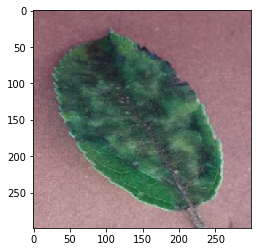

<Figure size 432x288 with 0 Axes>

SOURCE: class: Blueberry___healthy, file: Blueberry___healthy/c0c3498a-4b3c-49b0-b44f-2b3f0d7a6ebb___RS_HL 2372.JPG
Blueberry___healthy/c0c3498a-4b3c-49b0-b44f-2b3f0d7a6ebb___RS_HL 2372.JPG : [[[199 192 199]
  [211 204 211]
  [224 217 224]
  ...
  [212 205 210]
  [218 211 216]
  [212 205 210]]

 [[205 198 205]
  [206 199 206]
  [214 207 214]
  ...
  [211 204 209]
  [213 206 211]
  [211 204 209]]

 [[208 201 208]
  [198 191 198]
  [201 194 201]
  ...
  [200 193 198]
  [198 191 196]
  [214 207 212]]

 ...

 [[158 151 164]
  [129 122 135]
  [160 153 166]
  ...
  [169 161 172]
  [167 159 170]
  [173 165 176]]

 [[139 132 145]
  [145 138 151]
  [124 117 130]
  ...
  [160 152 163]
  [160 152 163]
  [164 156 167]]

 [[154 147 160]
  [146 139 152]
  [156 149 162]
  ...
  [163 155 166]
  [166 158 169]
  [171 163 174]]]
resized: [[[199 192 199]
  [208 201 208]
  [219 212 219]
  ...
  [214 207 212]
  [217 210 215]
  [212 205 210]]

 [[204 197 204]
  [206 199 206]
  [213 206 213]
  ...
  [212 205 

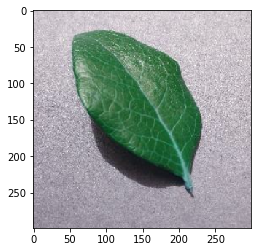

SOURCE: class: Tomato___Bacterial_spot, file: Tomato___Bacterial_spot/e818ebcc-f37e-41c7-beae-0cb76e113a36___UF.GRC_BS_Lab Leaf 8705.JPG
Tomato___Bacterial_spot/e818ebcc-f37e-41c7-beae-0cb76e113a36___UF.GRC_BS_Lab Leaf 8705.JPG : [[[114 110 109]
  [127 123 122]
  [134 130 129]
  ...
  [126 126 126]
  [129 129 129]
  [135 135 135]]

 [[128 124 123]
  [134 130 129]
  [130 126 125]
  ...
  [121 121 121]
  [121 121 121]
  [124 124 124]]

 [[147 143 142]
  [148 144 143]
  [140 136 135]
  ...
  [126 126 126]
  [125 125 125]
  [126 126 126]]

 ...

 [[147 149 149]
  [145 147 147]
  [144 146 146]
  ...
  [136 138 138]
  [136 138 138]
  [135 137 137]]

 [[148 150 150]
  [147 149 149]
  [145 147 147]
  ...
  [135 137 137]
  [131 133 133]
  [130 132 132]]

 [[144 146 146]
  [146 148 148]
  [148 150 150]
  ...
  [132 134 134]
  [128 130 130]
  [127 129 129]]]
resized: [[[114 110 109]
  [124 120 119]
  [131 127 126]
  ...
  [127 127 127]
  [130 130 130]
  [135 135 135]]

 [[125 121 120]
  [131 127 

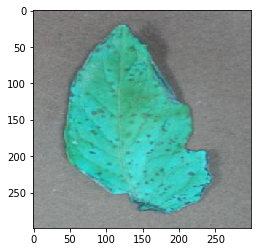

<Figure size 432x288 with 0 Axes>

SOURCE: class: Tomato___healthy, file: Tomato___healthy/29265f8d-86ff-4de1-b1ad-e33a64b189dc___RS_HL 0264.JPG
Tomato___healthy/29265f8d-86ff-4de1-b1ad-e33a64b189dc___RS_HL 0264.JPG : [[[ 82  72  84]
  [128 118 130]
  [ 83  73  85]
  ...
  [162 154 161]
  [125 117 124]
  [123 115 122]]

 [[116 106 118]
  [105  95 107]
  [ 80  70  82]
  ...
  [115 107 114]
  [166 158 165]
  [103  95 102]]

 [[ 77  67  79]
  [ 73  63  75]
  [114 104 116]
  ...
  [192 184 191]
  [189 181 188]
  [ 91  83  90]]

 ...

 [[121 106 114]
  [162 147 155]
  [129 114 122]
  ...
  [206 188 195]
  [134 116 123]
  [158 140 147]]

 [[126 111 119]
  [127 112 120]
  [148 133 141]
  ...
  [144 126 133]
  [161 143 150]
  [137 119 126]]

 [[138 123 131]
  [182 167 175]
  [145 130 138]
  ...
  [178 160 167]
  [137 119 126]
  [161 143 150]]]
resized: [[[ 82  72  84]
  [118 108 120]
  [ 99  89 101]
  ...
  [149 141 148]
  [124 116 123]
  [123 115 122]]

 [[108  99 111]
  [109 100 112]
  [ 91  81  93]
  ...
  [137 129 136]
  [1

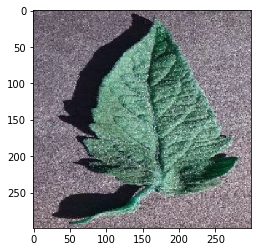

<Figure size 432x288 with 0 Axes>

SOURCE: class: Corn_(maize)___healthy, file: Corn_(maize)___healthy/d29534b3-d6b4-4a08-8c52-823b47c1f03e___R.S_HL 8288 copy.jpg
Corn_(maize)___healthy/d29534b3-d6b4-4a08-8c52-823b47c1f03e___R.S_HL 8288 copy.jpg : [[[118 140  92]
  [112 134  86]
  [110 132  84]
  ...
  [125 151  97]
  [133 159 105]
  [140 166 112]]

 [[112 134  86]
  [109 131  83]
  [110 132  84]
  ...
  [130 156 102]
  [130 156 102]
  [129 155 101]]

 [[110 132  84]
  [111 133  85]
  [113 137  89]
  ...
  [132 158 104]
  [123 149  95]
  [115 141  87]]

 ...

 [[135 167 118]
  [135 167 118]
  [133 165 116]
  ...
  [100 161 103]
  [100 161 103]
  [ 96 157  99]]

 [[136 168 119]
  [134 166 117]
  [131 163 114]
  ...
  [ 98 159 101]
  [ 98 159 101]
  [ 94 155  97]]

 [[136 168 119]
  [134 166 117]
  [130 162 113]
  ...
  [ 96 157  99]
  [ 95 156  98]
  [ 91 152  94]]]
resized: [[[118 140  92]
  [113 135  87]
  [111 133  85]
  ...
  [128 154 100]
  [134 160 106]
  [140 166 112]]

 [[113 135  87]
  [110 132  84]
  [110 132  

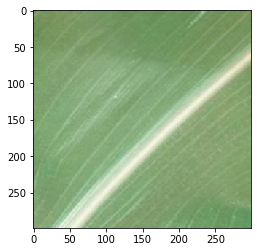

<Figure size 432x288 with 0 Axes>

In [0]:
IMAGE_SHAPE = (299, 299)
for idx, filename in enumerate(random.sample(validation_generator.filenames, 5)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [0]:
cv2.__version__

'4.1.2'

In [0]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
tf.keras.experimental.export_saved_model(new_model, export_path)

export_path

In [0]:
reloaded = tf.keras.experimental.load_from_saved_model("checkpoint")

In [0]:
new_model = tf.keras.models.load_model("checkpoint")

In [0]:
new_model.predict()

In [0]:
# convert the model to TFLite
!mkdir "tflite_models"
TFLITE_MODEL = "tflite_models/plant_disease_model.tflite"

In [0]:
# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : new_model(x))

In [0]:
# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(new_model.inputs[0].shape, new_model.inputs[0].dtype)
)

In [0]:
# Convert the model to standard TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

In [0]:
tf.__version__

In [0]:
!mkdir training_1_15
!ls

In [0]:
import datetime
filename = "test_{}.hdf5".format(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S"))
model.save("training_1_15", save_format='tf')